In [1]:
import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

import json
from pathlib import Path

%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

# Appends the entire brainstation_capstone project folder to the path.
# This allows us to make a relative import of our scripts in brainstation_capstone/scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from utilities import utils

# **Cleaning Lyrics**
Author: Justin Ng

This notebook contains all the steps for converting lyrics into various representations.

We first need to load the data and clean the lyrics.

## Loading the Data

In [4]:
# Set path for the raw data
DATA_PATH = utils.get_datapath('data')

In [5]:
# Load the lyrics.
lyrics_df = utils.json_loader(DATA_PATH / 'genius-expertise' / 'lyrics.jl')

In [6]:
display(lyrics_df.info())
display(lyrics_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37993 entries, 0 to 37992
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   song    37993 non-null  object
 1   lyrics  37993 non-null  object
dtypes: object(2)
memory usage: 593.8+ KB


None

(37993, 2)

In [7]:
# Load the song info.
song_info_df = utils.json_loader(DATA_PATH / 'genius-expertise'/ 'song_info.json')

In [8]:
display(song_info_df.info())
display(song_info_df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223257 entries, 0 to 223256
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   url_name        223257 non-null  object 
 1   title           223257 non-null  object 
 2   primary_artist  223257 non-null  object 
 3   release_date    176884 non-null  object 
 4   pyongs          223256 non-null  float64
 5   contributors    223257 non-null  int64  
 6   has_bio         223257 non-null  bool   
 7   views           72065 non-null   float64
 8   tags            223257 non-null  object 
 9   annotations     0 non-null       float64
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 15.5+ MB


None

(223257, 10)

In [9]:
song_info_df.isna().mean()

url_name          0.000000
title             0.000000
primary_artist    0.000000
release_date      0.207711
pyongs            0.000004
contributors      0.000000
has_bio           0.000000
views             0.677211
tags              0.000000
annotations       1.000000
dtype: float64

In [10]:
song_info_df = song_info_df[
    song_info_df.columns.difference(['annotations'])
    ].dropna(axis=0)

In [149]:
def date_converter(dates):
    year = []

    for date in dates:
        try:
            split_date = date.replace(',', '').split()
            if len(split_date) > 1:
                year.append(int(split_date[2]))
            # If there is only the year. 
            elif len(split_date) == 1:
                year.append(int(split_date[0]))
        except:
            year.append(np.nan)

    return year

In [150]:
year = date_converter(song_info_df.release_date)

In [151]:
year = np.array(year)

In [152]:
year = year[~np.isnan(year)]

In [153]:
year.min()

971.0

Seems like theres an error in the data for the release year of 1971.

The following checks to see that all songs with 971 are from the year 1971.

In [155]:
for _, row in song_info_df.iterrows():
    if '971' in row['release_date']:
        print(row['title'])
    

Never Can Say Goodbye
Got to Be There
Echoes
Fearless
One of These Days
A Pillow of Winds
San Tropez
Seamus
Life on Mars?
Oh! You Pretty Things
Quicksand
Queen Bitch
The Bewlay Brothers
Andy Warhol
Kooks
Song for Bob Dylan
Fill Your Heart
Stairway to Heaven
Black Dog
Going to California
When the Levee Breaks
The Battle of Evermore
Rock and Roll
Misty Mountain Hop
Four Sticks
I Shall Be Released
You Ain’t Goin’ Nowhere
Tomorrow Is a Long Time
Too Many People
Uncle Albert/Admiral Halsey
Another Day
Monkberry Moon Delight
Dear Friend
Ram On
Dear Boy
Wild Horses
Brown Sugar
Dead Flowers
Can’t You Hear Me Knocking
Bitch
Sway
Moonlight Mile
I Got the Blues
Riders on the Storm
L.A. Woman
Love Her Madly
The WASP (Texas Radio and the Big Beat)
Been Down So Long
Hyacinth House
The Changeling
Cars Hiss by My Window
L’America
Crawling King Snake
Iron Man
Sweet Leaf
Children of the Grave
Solitude
Into the Void
After Forever
Lord of this World
Day After Day
It Don’t Come Easy
The Mothering Blackness

In [154]:
year.max()

2020.0

In [176]:
def date_converter(dates):
    year = []

    for date in dates:
        split_date = date.replace(',', '').split()
        if len(split_date) > 1:
            if '971' in split_date[-1]:
                year.append(1971)
            else:
                year.append(int(split_date[-1]))
        # If there is only the year. 
        elif len(split_date) == 1:
            if '971' in split_date[0]:
                year.append(1971)
            else:
                year.append(int(split_date[0]))
    

    return year

In [177]:
year = date_converter(song_info_df.release_date)

In [178]:
np.array(year).min(), np.array(year).max()

(1595, 2020)

In [179]:
for _, row in song_info_df.iterrows():
    if '1595' in row['release_date']:
        print(row['title'])

Romeo and Juliet Act 2 Scene 4


In [10]:
# Rename song column to merge on.
song_info_df.rename(
    {'url_name': 'song'},
    axis=1,
    inplace= True
)

# Merge the song views with the lyrics. 
raw_combined_df = pd.merge(
    lyrics_df, 
    song_info_df[['song', 'title', 'views']].dropna(axis=0),
    on='song',

)

In [11]:
# Raw uncleaned df.
display(raw_combined_df.head(10))
display(raw_combined_df.shape)
display(raw_combined_df.info())

,song,lyrics,title,views
0,Kendrick-lamar-swimming-pools-drank-lyrics,\n\n[Produced by T-Minus]\n\n[Intro]\nPour up ...,Swimming Pools (Drank),5589280.0
1,Kendrick-lamar-money-trees-lyrics,\n\n[Produced by DJ Dahi]\n\n[Verse 1: Kendric...,Money Trees,4592003.0
2,Kendrick-lamar-xxx-lyrics,"\n\n[Intro: Bēkon & Kid Capri]\nAmerica, God b...",XXX.,4651514.0
3,A-ap-rocky-fuckin-problems-lyrics,"\n\n[Chorus: 2 Chainz, Drake & Both (A$AP Rock...",Fuckin’ Problems,7378309.0
4,Kendrick-lamar-dna-lyrics,"\n\n[Verse 1]\nI got, I got, I got, I got—\nLo...",DNA.,5113687.0
5,Kendrick-lamar-poetic-justice-lyrics,\n\n[Produced by Scoop DeVille & Sounwave]\n\n...,Poetic Justice,4137688.0
6,Kendrick-lamar-bitch-dont-kill-my-vibe-lyrics,\n\n[Produced by Sounwave]\n\n[Chorus]\nI am a...,"Bitch, Don’t Kill My Vibe",4455762.0
7,Kendrick-lamar-king-kunta-lyrics,\n\n[Produced by Sounwave; Additional producti...,King Kunta,3976102.0
8,Kendrick-lamar-element-lyrics,\n\n[Intro: Kid Capri & Kendrick Lamar]\nNew K...,ELEMENT.,2506800.0
9,Kendrick-lamar-the-blacker-the-berry-lyrics,\n\n[Produced by Boi-1da & Koz]\n\n[Intro: Ken...,The Blacker the Berry,2557473.0


(37905, 4)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37905 entries, 0 to 37904
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   song    37905 non-null  object 
 1   lyrics  37905 non-null  object 
 2   title   37905 non-null  object 
 3   views   37905 non-null  float64
dtypes: float64(1), object(3)
memory usage: 1.4+ MB


None

In [12]:
raw_combined_df.head()

,song,lyrics,title,views
0,Kendrick-lamar-swimming-pools-drank-lyrics,\n\n[Produced by T-Minus]\n\n[Intro]\nPour up ...,Swimming Pools (Drank),5589280.0
1,Kendrick-lamar-money-trees-lyrics,\n\n[Produced by DJ Dahi]\n\n[Verse 1: Kendric...,Money Trees,4592003.0
2,Kendrick-lamar-xxx-lyrics,"\n\n[Intro: Bēkon & Kid Capri]\nAmerica, God b...",XXX.,4651514.0
3,A-ap-rocky-fuckin-problems-lyrics,"\n\n[Chorus: 2 Chainz, Drake & Both (A$AP Rock...",Fuckin’ Problems,7378309.0
4,Kendrick-lamar-dna-lyrics,"\n\n[Verse 1]\nI got, I got, I got, I got—\nLo...",DNA.,5113687.0


## Cleaning the Lyrics

In [13]:
raw_combined_df['cleaned_lyrics'] = raw_combined_df['lyrics'].apply(utils.clean_lyrics)

In [14]:
display(raw_combined_df.head()),
raw_combined_df.shape

,song,lyrics,title,views,cleaned_lyrics
0,Kendrick-lamar-swimming-pools-drank-lyrics,\n\n[Produced by T-Minus]\n\n[Intro]\nPour up ...,Swimming Pools (Drank),5589280.0,pour up drank head shot drank sit down drank ...
1,Kendrick-lamar-money-trees-lyrics,\n\n[Produced by DJ Dahi]\n\n[Verse 1: Kendric...,Money Trees,4592003.0,uh me and my niggas tryna get it ya bish ya b...
2,Kendrick-lamar-xxx-lyrics,"\n\n[Intro: Bēkon & Kid Capri]\nAmerica, God b...",XXX.,4651514.0,america god bless you if its good to you amer...
3,A-ap-rocky-fuckin-problems-lyrics,"\n\n[Chorus: 2 Chainz, Drake & Both (A$AP Rock...",Fuckin’ Problems,7378309.0,i love bad bitches thats my fuckin problem an...
4,Kendrick-lamar-dna-lyrics,"\n\n[Verse 1]\nI got, I got, I got, I got—\nLo...",DNA.,5113687.0,i got i got i got i got loyalty got royalty i...


(37905, 5)

# Detecting Language

Decided to use a pretrained Fasttext model trained for language detection. This is model performs faster than the Spacy language detection model. 
Fasttext Language detection model found [here](https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin)

In [25]:
from tqdm import tqdm
import fasttext

language = []
path_to_pretrained_model = utils.get_datapath('data') / 'language_detect' / 'lid.176.bin'


In [27]:
# Model for language detection.
fmodel = fasttext.load_model(str(path_to_pretrained_model))


In [34]:
language = []

for lyric in tqdm(raw_combined_df['cleaned_lyrics']):
    # fasttext model.predict returns a tuple of the language label and a score. 
    # The language label is another tuple, where the 0 index is the actual language label itself.
    # This label is in the format '__label__en'. So need to index the last two characters to get the actual language. 
    
    language.append(fmodel.predict(lyric)[0][0][-2:])
    


100%|██████████| 37905/37905 [00:03<00:00, 9743.64it/s] 


In [39]:
# Number of unique languages
len(np.unique(np.array(language)))

26

In [40]:
raw_combined_df['language'] = language

# Exploring Views and Splitting Views

We will split the views based on how the distribution of the views look like. 

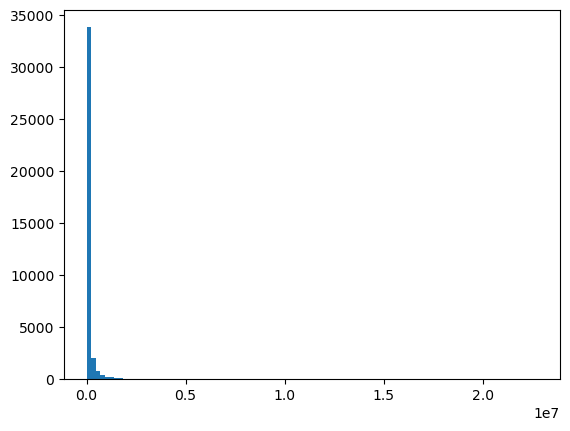

In [13]:
plt.hist(raw_combined_df['views'], bins=100);

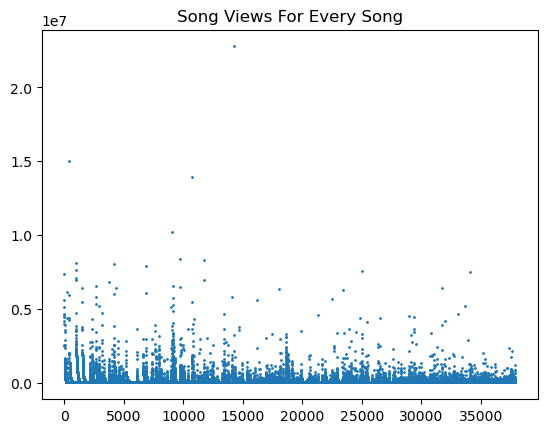

In [14]:
plt.figure()
plt.scatter(x=raw_combined_df.index, y=raw_combined_df['views'], s=1)
plt.title('Song views for every song'.title())
plt.show()

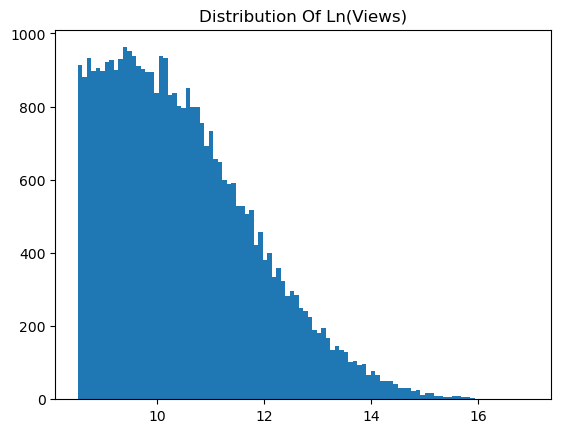

In [15]:
plt.figure()
plt.hist(np.log(raw_combined_df['views']), bins=100)
plt.title('Distribution of ln(views)'.title())
plt.show()

In [45]:
raw_combined_df['log_scaled_views'] = np.log(raw_combined_df['views'])
raw_combined_df.head()

,song,lyrics,title,views,cleaned_lyrics,language,log_scaled_views
0,Kendrick-lamar-swimming-pools-drank-lyrics,\n\n[Produced by T-Minus]\n\n[Intro]\nPour up ...,Swimming Pools (Drank),5589280.0,pour up drank head shot drank sit down drank ...,en,15.536361
1,Kendrick-lamar-money-trees-lyrics,\n\n[Produced by DJ Dahi]\n\n[Verse 1: Kendric...,Money Trees,4592003.0,uh me and my niggas tryna get it ya bish ya b...,en,15.339827
2,Kendrick-lamar-xxx-lyrics,"\n\n[Intro: Bēkon & Kid Capri]\nAmerica, God b...",XXX.,4651514.0,america god bless you if its good to you amer...,en,15.352703
3,A-ap-rocky-fuckin-problems-lyrics,"\n\n[Chorus: 2 Chainz, Drake & Both (A$AP Rock...",Fuckin’ Problems,7378309.0,i love bad bitches thats my fuckin problem an...,en,15.814055
4,Kendrick-lamar-dna-lyrics,"\n\n[Verse 1]\nI got, I got, I got, I got—\nLo...",DNA.,5113687.0,i got i got i got i got loyalty got royalty i...,en,15.447431


In [46]:
raw_combined_df['popular'] = pd.cut(
    raw_combined_df['log_scaled_views'], 
    bins = [0,raw_combined_df['log_scaled_views'].median(), raw_combined_df['log_scaled_views'].max()], 
    labels = [0,1]
    )

In [47]:
raw_combined_df['popular'].value_counts()

0    18953
1    18952
Name: popular, dtype: int64

In [48]:
raw_combined_df['popularity'] = pd.cut(
    raw_combined_df['log_scaled_views'], 
    bins = [
        0,
        raw_combined_df['log_scaled_views'].quantile(q=0.33), 
        raw_combined_df['log_scaled_views'].quantile(q=0.66),
        raw_combined_df['log_scaled_views'].max()
    ],
    labels=[0,1,2]
    )

In [49]:
raw_combined_df['popularity'].value_counts()

2    12887
0    12509
1    12509
Name: popularity, dtype: int64

Separating Popularity by Standard Deviation.

In [50]:
std = raw_combined_df.log_scaled_views.std()
mean = raw_combined_df.log_scaled_views.mean()

In [51]:
upper_range = mean + std

In [52]:
lower_range = mean - std

In [53]:
raw_combined_df['popularity_std'] = pd.cut(
    raw_combined_df['log_scaled_views'], 
    bins = [
        0,
        lower_range, 
        upper_range,
        raw_combined_df['log_scaled_views'].max()
    ],
    labels=[0,1,2]
)

In [54]:
english_songs_df = raw_combined_df[
    raw_combined_df['language'] == 'en'
]

In [57]:
english_songs_df.head()

,song,lyrics,title,views,cleaned_lyrics,language,log_scaled_views,popular,popularity,popularity_std
0,Kendrick-lamar-swimming-pools-drank-lyrics,\n\n[Produced by T-Minus]\n\n[Intro]\nPour up ...,Swimming Pools (Drank),5589280.0,pour up drank head shot drank sit down drank ...,en,15.536361,1,2,2
1,Kendrick-lamar-money-trees-lyrics,\n\n[Produced by DJ Dahi]\n\n[Verse 1: Kendric...,Money Trees,4592003.0,uh me and my niggas tryna get it ya bish ya b...,en,15.339827,1,2,2
2,Kendrick-lamar-xxx-lyrics,"\n\n[Intro: Bēkon & Kid Capri]\nAmerica, God b...",XXX.,4651514.0,america god bless you if its good to you amer...,en,15.352703,1,2,2
3,A-ap-rocky-fuckin-problems-lyrics,"\n\n[Chorus: 2 Chainz, Drake & Both (A$AP Rock...",Fuckin’ Problems,7378309.0,i love bad bitches thats my fuckin problem an...,en,15.814055,1,2,2
4,Kendrick-lamar-dna-lyrics,"\n\n[Verse 1]\nI got, I got, I got, I got—\nLo...",DNA.,5113687.0,i got i got i got i got loyalty got royalty i...,en,15.447431,1,2,2


In [56]:
english_songs_df.to_csv(DATA_PATH / 'clean_lyrics.csv')